In [1]:
# Dependencies and Setup
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# from scipy.stats import sem
import os
import pylab 
import scipy.stats as stats
import matplotlib as mpl

plt.style.use('ggplot')
%matplotlib inline
# import DataProcessor as dp

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

taxi_file_names = {
    "2018_01": 'Desktop/TaxiData/yellow_tripdata_2018-01.csv'
}
taxi_zone_lkup_csv='Desktop/TaxiData/taxi_zone_lookup.csv'



In [2]:







# Storing Filenames to Load
#taxi_file_names = {
    #"2018_01": os.path.join("..", "TaxiData", "yellow_tripdata_2018-01.csv"),
#     "2018_02": os.path.join("..", "TaxiData", "yellow_tripdata_2018-02.csv"),
#     "2018_03": os.path.join("..", "TaxiData", "yellow_tripdata_2018-03.csv"),
#     "2018_04": os.path.join("..", "TaxiData", "yellow_tripdata_2018-04.csv"),
#     "2018_05": os.path.join("..", "TaxiData", "yellow_tripdata_2018-05.csv"),
#     "2018_06": os.path.join("..", "TaxiData", "yellow_tripdata_2018-06.csv"),
#     "2018_07": os.path.join("..", "TaxiData", "yellow_tripdata_2018-07.csv"),
#     "2018_08": os.path.join("..", "TaxiData", "yellow_tripdata_2018-08.csv"),
#     "2018_09": os.path.join("..", "TaxiData", "yellow_tripdata_2018-09.csv"),
#     "2018_10": os.path.join("..", "TaxiData", "yellow_tripdata_2018-10.csv"),
#     "2018_11": os.path.join("..", "TaxiData", "yellow_tripdata_2018-11.csv"),
#     "2018_12": os.path.join("..", "TaxiData", "yellow_tripdata_2018-12.csv")
#}

#taxi_zone_lkup_csv = os.path.join("..","TaxiData", "taxi_zone_lookup.csv")

In [3]:
def retrieve_summary(zone_lkup_file, taxi_file_names, gb_field):
    taxi_zone_lkup_df = pd.read_csv(taxi_zone_lkup_csv)
    # chunk_list = []  # append each chunk df here     
    gb_field_list = ["trip_count","total_revenue","total_time_min","total_miles"]

    gb_final_file_df = pd.DataFrame()

    for file_key in taxi_file_names: 
        clean_file_df = clean_file(taxi_file_names[file_key], taxi_zone_lkup_df, file_key, gb_field)
        gb_clean_file_df = groupby(clean_file_df, gb_field, gb_field_list)
        gb_final_file_df = gb_final_file_df.append(gb_clean_file_df)
        print(file_key)

    gb_final_file_df = groupby(gb_final_file_df, gb_field, gb_field_list)
    gb_final_file_df = enrich_summary(gb_final_file_df)
    
    return gb_final_file_df




In [4]:

def enrich_summary(df):
    new_df = df
    new_df['avg_min_ptrip'] = new_df['total_time_min']/new_df['trip_count']
    new_df['avg_dist_ptrip'] = new_df['total_miles']/new_df['trip_count']
    new_df['avg_rev_ptrip'] = new_df['total_revenue']/new_df['trip_count']
    
    new_df['avg_dist_pmin'] = new_df['total_miles']/new_df['total_time_min']
    new_df['avg_rev_pmin'] = new_df['total_revenue']/new_df['total_time_min']
    
    new_df['rev_per_dist'] = new_df['total_revenue']/new_df['total_miles']

    
    return new_df

In [5]:
def clean_file(csv, taxi_zone_lkup_df, file_key, gb_field):
    
    chunks_df = pd.read_csv(csv, chunksize=1000000)    
    gb_field_list = ["PULocationID","total_amount","trip_time_min","trip_distance"]
    
    new_gb_df = pd.DataFrame()    
    
    for chunk_df in chunks_df:  
        clean_chunk_df = clean_chunk(chunk_df, taxi_zone_lkup_df, file_key)
        gb_clean_chunk_df = groupby(clean_chunk_df, gb_field, gb_field_list)
        # Once the data filtering is done, append the chunk to list
        new_gb_df = new_gb_df.append(gb_clean_chunk_df)
    return new_gb_df


In [6]:
def clean_chunk(df, zone_lkup_df, file_key):
    new_df = remove_unwanted_columns(df)
    new_df = remove_unwanted_rows(new_df, file_key)
    new_df = add_new_columns(new_df, zone_lkup_df)
    return new_df


In [7]:
def remove_unwanted_columns(df):
    new_df = df.drop(['VendorID', 'store_and_fwd_flag','fare_amount',
                    'extra', 'mta_tax','tolls_amount',
                    'improvement_surcharge'], axis=1) 
    return new_df

In [8]:
def remove_unwanted_rows(df, file_key):
    new_df = df 
    new_df['year'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).year
    new_df['month'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).month
    
    file_month = file_key.split("_")[1]
    file_year = file_key.split("_")[0] 

    new_df = new_df.loc[(new_df["month"] == float(file_month)) & 
                        (new_df["year"] == float(file_year)), :]

#     new_df = df.drop(['year', 'month'], axis=1)    

    return new_df

In [9]:
def add_new_columns(df, zone_lkup_df):
    #set convert lkup_df to dictionary to leverage 'map' method
    taxi_zone_dic = pd.Series(zone_lkup_df.Zone.values, index=zone_lkup_df.LocationID).to_dict()

    new_df = df
    #create 2 columns for zone_name
    new_df['PU_zone_name'] = new_df.PULocationID.map(taxi_zone_dic)
    new_df['DO_zone_name'] = new_df.DOLocationID.map(taxi_zone_dic)

    #create 2 columns for time
    new_df['trip_time'] = pd.to_datetime(new_df["tpep_dropoff_datetime"]) - pd.to_datetime(new_df["tpep_pickup_datetime"])
    new_df['trip_time_min'] = new_df['trip_time'].dt.total_seconds()/60
    
    new_df['day_of_week'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.day_name()
    new_df['hour_of_day'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.hour

    
    return new_df

In [10]:
def groupby(df, gb_field_name, fields):
    groupby = df.groupby([gb_field_name])
    gb_trip_rev_total = groupby[fields[1]].sum()
    gb_trip_time_total = groupby[fields[2]].sum()
    gb_trip_miles_total = groupby[fields[3]].sum()
    
    if fields[0] == 'trip_count':
        gb_trip_count = groupby[fields[0]].sum()
    else:
        gb_trip_count = groupby[fields[0]].count()
        
    new_df = pd.DataFrame({"trip_count": gb_trip_count,
                          "total_revenue": gb_trip_rev_total,
                          "total_time_min": gb_trip_time_total,
                          "total_miles": gb_trip_miles_total})
    
    return new_df

In [11]:
#################
'variable names'
#################
'PU_zone_name'
'month'    
'day_of_week'
'hour_of_day'    
'RatecodeID'     
#################

#start = datetime.datetime.today()
# key_variables['PU_zone_name','month','day_of_week','hour_of_day','RatecodeID'] 
#retrieves a summary from a years worth of data for a given variable
passenger_count_number_df = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "passenger_count")

#end = datetime.datetime.today()
passenger_count_number_df

2018_01


,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
passenger_count,,,,,,,,,,
0,59269,8.916183e+05,7.497981e+05,153171.81,12.650763,2.584349,15.043586,0.204284,1.189145,5.821034
1,6248630,9.601183e+07,9.489731e+07,17325601.76,15.186898,2.772704,15.365261,0.182572,1.011745,5.541616
2,1271552,2.034077e+07,2.097211e+07,3704180.84,16.493321,2.913118,15.996808,0.176624,0.969896,5.491301
3,351896,5.561573e+06,5.914283e+06,1014092.88,16.806906,2.881797,15.804593,0.171465,0.940363,5.484284
4,163555,2.584187e+06,2.738749e+06,473190.22,16.745124,2.893157,15.800111,0.172776,0.943565,5.461202
5,414441,6.436011e+06,7.379692e+06,1182297.07,17.806376,2.852751,15.529378,0.160210,0.872125,5.443649
6,250102,3.862597e+06,4.486950e+06,708837.83,17.940478,2.834195,15.444086,0.157978,0.860851,5.449197
7,38,2.199430e+03,1.724883e+03,98.73,45.391667,2.598158,57.879737,0.057239,1.275118,22.277221
8,24,1.227520e+03,1.383500e+02,60.64,5.764583,2.526667,51.146667,0.438309,8.872570,20.242744


In [12]:
passenger_count_number_df.head(5)

,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
passenger_count,,,,,,,,,,
0,59269,8.916183e+05,7.497981e+05,153171.81,12.650763,2.584349,15.043586,0.204284,1.189145,5.821034
1,6248630,9.601183e+07,9.489731e+07,17325601.76,15.186898,2.772704,15.365261,0.182572,1.011745,5.541616
2,1271552,2.034077e+07,2.097211e+07,3704180.84,16.493321,2.913118,15.996808,0.176624,0.969896,5.491301
3,351896,5.561573e+06,5.914283e+06,1014092.88,16.806906,2.881797,15.804593,0.171465,0.940363,5.484284
4,163555,2.584187e+06,2.738749e+06,473190.22,16.745124,2.893157,15.800111,0.172776,0.943565,5.461202


In [13]:
passenger_count_number_df.tail()

,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
passenger_count,,,,,,,,,,
5,414441,6.436011e+06,7.379692e+06,1182297.07,17.806376,2.852751,15.529378,0.160210,0.872125,5.443649
6,250102,3.862597e+06,4.486950e+06,708837.83,17.940478,2.834195,15.444086,0.157978,0.860851,5.449197
7,38,2.199430e+03,1.724883e+03,98.73,45.391667,2.598158,57.879737,0.057239,1.275118,22.277221
8,24,1.227520e+03,1.383500e+02,60.64,5.764583,2.526667,51.146667,0.438309,8.872570,20.242744
9,25,1.596030e+03,2.005000e+02,102.48,8.020000,4.099200,63.841200,0.511122,7.960249,15.574063


In [14]:
RatecodeID_df = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "RatecodeID")
RatecodeID_df.head()

2018_01


,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
RatecodeID,,,,,,,,,,
1,8532167,1.201973e+08,1.274260e+08,21000104.02,14.934771,2.461286,14.087541,0.164802,0.943271,5.723650
2,179257,1.177156e+07,8.341323e+06,3053648.38,46.532762,17.035030,65.668599,0.366087,1.411234,3.854915
3,15127,1.355929e+06,6.680948e+05,252260.02,44.165716,16.676143,89.636348,0.377581,2.029546,5.375125
4,5079,3.975533e+05,2.194367e+05,90928.46,43.204706,17.902827,78.273922,0.414372,1.811699,4.372154
5,27727,1.965135e+06,4.859865e+05,164614.04,17.527556,5.936958,70.874421,0.338721,4.043600,11.937834


In [15]:
preview_df=passenger_count_number_df[['trip_count','total_time_min','total_miles','avg_rev_pmin','rev_per_dist']]
preview_df.sort_values(by='avg_rev_pmin',ascending=False).head(7)

,trip_count,total_time_min,total_miles,avg_rev_pmin,rev_per_dist
passenger_count,,,,,
8,24,1.383500e+02,60.64,8.872570,20.242744
9,25,2.005000e+02,102.48,7.960249,15.574063
7,38,1.724883e+03,98.73,1.275118,22.277221
0,59269,7.497981e+05,153171.81,1.189145,5.821034
1,6248630,9.489731e+07,17325601.76,1.011745,5.541616
2,1271552,2.097211e+07,3704180.84,0.969896,5.491301
4,163555,2.738749e+06,473190.22,0.943565,5.461202


In [16]:
passenger_count_number_df.sort_values(by='avg_rev_pmin',ascending=False).head(5)

,trip_count,total_revenue,total_time_min,total_miles,avg_min_ptrip,avg_dist_ptrip,avg_rev_ptrip,avg_dist_pmin,avg_rev_pmin,rev_per_dist
passenger_count,,,,,,,,,,
8,24,1.227520e+03,1.383500e+02,60.64,5.764583,2.526667,51.146667,0.438309,8.872570,20.242744
9,25,1.596030e+03,2.005000e+02,102.48,8.020000,4.099200,63.841200,0.511122,7.960249,15.574063
7,38,2.199430e+03,1.724883e+03,98.73,45.391667,2.598158,57.879737,0.057239,1.275118,22.277221
0,59269,8.916183e+05,7.497981e+05,153171.81,12.650763,2.584349,15.043586,0.204284,1.189145,5.821034
1,6248630,9.601183e+07,9.489731e+07,17325601.76,15.186898,2.772704,15.365261,0.182572,1.011745,5.541616


In [17]:
over_1_passenger = passenger_count_number_df[passenger_count_number_df['avg_rev_pmin']<6]
over_1_passenger = passenger_count_number_df[['trip_count','total_time_min','total_miles','avg_rev_pmin','rev_per_dist']]

#get group and single passenger count based on revenue per minute
passenger_count_number_revpmin = over_1_passenger.sort_values(by=['avg_rev_pmin'],ascending=False).reset_index().head(5)
passenger_count_number_revpdist = over_1_passenger.sort_values(by='rev_per_dist',ascending=False).reset_index().head(5)

In [18]:
passenger_count_number_revpmin

,passenger_count,trip_count,total_time_min,total_miles,avg_rev_pmin,rev_per_dist
0,8,24,1.383500e+02,60.64,8.872570,20.242744
1,9,25,2.005000e+02,102.48,7.960249,15.574063
2,7,38,1.724883e+03,98.73,1.275118,22.277221
3,0,59269,7.497981e+05,153171.81,1.189145,5.821034
4,1,6248630,9.489731e+07,17325601.76,1.011745,5.541616


In [19]:
over_1_passenger = passenger_count_number_df[passenger_count_number_df['rev_per_dist']<6]
over_1_passenger = passenger_count_number_df[['trip_count','total_time_min','total_miles','avg_rev_pmin','rev_per_dist']]

#get group and single passenger count based on revenue per distance
passenger_count_number_revpdist = over_1_passenger.sort_values(by=['rev_per_dist'],ascending=False).reset_index().head(5)
passenger_count_number_revpmin = over_1_passenger.sort_values(by='avg_rev_pmin',ascending=False).reset_index().head(5)

In [20]:
passenger_count_number_revpdist

,passenger_count,trip_count,total_time_min,total_miles,avg_rev_pmin,rev_per_dist
0,7,38,1.724883e+03,98.73,1.275118,22.277221
1,8,24,1.383500e+02,60.64,8.872570,20.242744
2,9,25,2.005000e+02,102.48,7.960249,15.574063
3,0,59269,7.497981e+05,153171.81,1.189145,5.821034
4,1,6248630,9.489731e+07,17325601.76,1.011745,5.541616


In [25]:
new_df=passenger_count_number_df.reset_index()

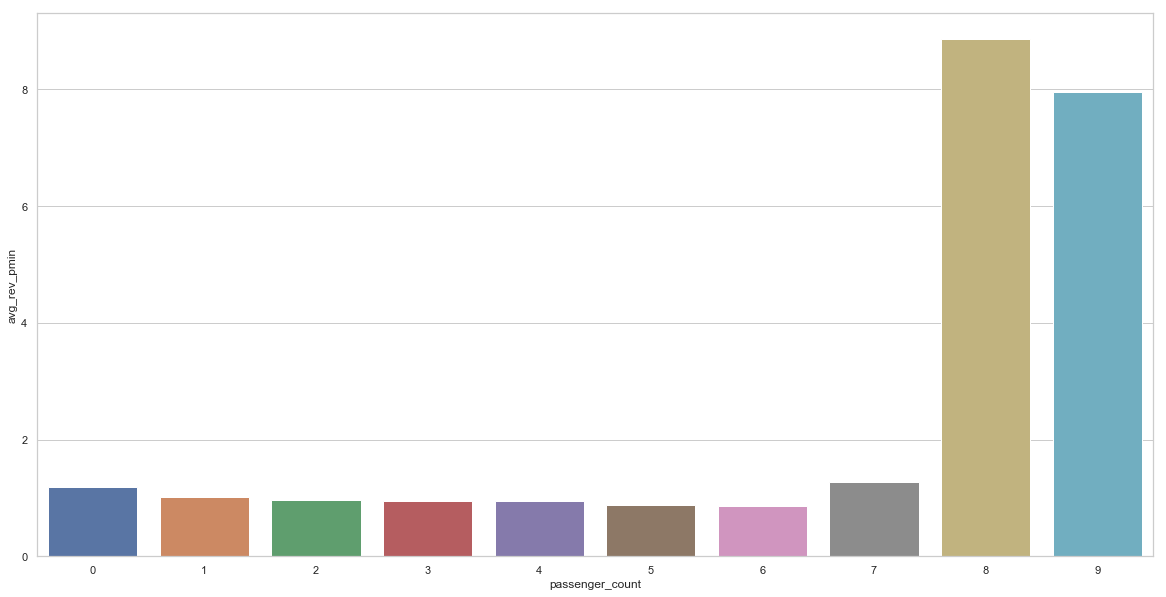

In [50]:
import seaborn as sns
sns.set_style("whitegrid")
#Create plot of passenger count vs average revenue per min %

ax = sns.barplot(y=new_df["avg_rev_pmin"], x=new_df["passenger_count"], 
                 data=new_df,errwidth=None,ci=None)
sns.set(font_scale=1)
#plt.title("Passener Count vs Average Revenue Per Minute")
# for p in ax.patches:
#     width = p.get_width()
#     plt.text(3+p.get_width(), p.get_y()+0.2*p.get_height(),
#              '{:1.2f}'.format(width),
#              ha='center', va='center')

#plt.xlim(10,35)
#plt.show()



In [55]:
plt.savefig("Passenger_Count_vs_avg_rev_pmin.png",bbox_inches='tight')

<Figure size 1440x720 with 0 Axes>

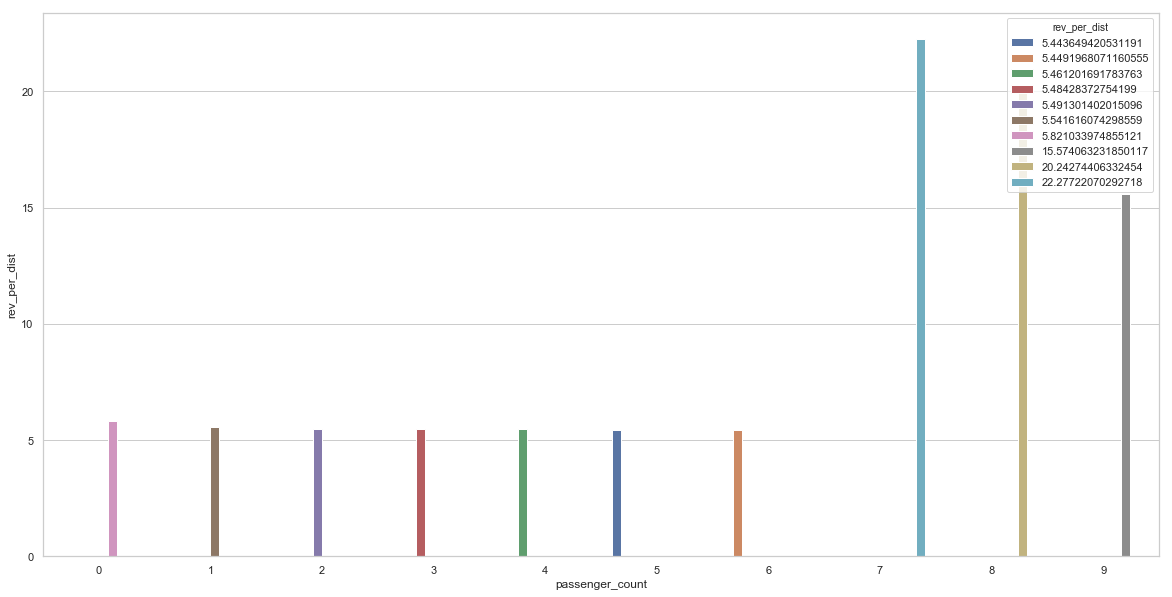

In [51]:
#Create plot of passengers vs rev per distance % for 
#import seaborn as sns
sns.set_style("whitegrid")

ax = sns.barplot(y=new_df["rev_per_dist"], x=new_df["passenger_count"], 
                 data=new_df,errwidth=None,ci=None,hue=new_df["rev_per_dist"])

# plt.title("Single vs Group Passenger Trip Distances in January 2018'")
# for p in ax.patches:
# width = p.get_width()
# plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
#               '{:1.2f}'.format(width),
#               ha='center', va='center')

# plt.xlim(10,40)
# #plt.savefig("Single vs Group PAssengers Trip Distances in Ja.png",bbox_inches='tight')
# plt.show()

In [54]:
plt.savefig("passenger_count_vs_rev_per_dist.png",bbox_inches='tight')

<Figure size 1440x720 with 0 Axes>

In [45]:
RatecodeID_df['avg_rev_pmin'].describe()

count      7.000000
mean      20.633346
std       43.016116
min        0.943271
25%        1.611466
50%        2.029546
75%       10.441140
max      117.355391
Name: avg_rev_pmin, dtype: float64

In [46]:
RatecodeID_df['rev_per_dist'].describe()

count      7.000000
mean     114.208681
std      276.742338
min        3.854915
25%        4.873639
50%        5.723650
75%       19.299919
max      741.535088
Name: rev_per_dist, dtype: float64